In [32]:
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split

In [140]:
with open ('review_sentiment_score_updated.csv', 'r') as review:
    df = pd.read_csv(review, index_col='index')
    df = df.drop(['Unnamed: 0'], axis=1)

In [249]:
df.loc[1,['vader_pos', 'senticnet_pos', 'pattern_pos']]

vader_pos        0.223286
senticnet_pos    0.452878
pattern_pos       0.20377
Name: 1, dtype: object

In [251]:
for i in range(len(df)):
    df.loc[i,'avg_pos'] = df.loc[i,['vader_pos', 'senticnet_pos', 'pattern_pos']].mean()
    df.loc[i,'avg_neg'] = df.loc[i,['vader_neg', 'senticnet_neg', 'pattern_neg']].mean()
    df.loc[i,'avg_sentiment'] = df.iloc[i,3:9].mean()

In [359]:
# remove some outliers that using many negative words but the rate is very positive
# those points would have serious influence on the prediction model.
for i in range(len(df.index)):
    pos = df.loc[i,'avg_pos']
    sentiment = df.loc[i,'avg_sentiment']
    rate = df.loc[i,'rate']
    if sentiment < 0 and rate >5:
        df.loc[i, 'classes'] = 'noneed'
    elif pos < 0.25 and rate >5:
        df.loc[i, 'classes'] = 'noneed'
    elif sentiment > 0 and rate <5:
        df.loc[i, 'classes'] = 'noneed'
    else:
        df.loc[i, 'classes'] = 'keep'

df_no_outlier = df[df.classes == 'keep']

In [360]:
df_no_outlier
#sentment = df.loc[0,'avg_sentiment']
#sent
#type(df.loc[0,'avg_pos'])

,movie,body,rate,vader_pos,vader_neg,senticnet_pos,senticnet_neg,pattern_pos,pattern_neg,avg_sentiment,classes,avg_pos,avg_neg
index,,,,,,,,,,,,,
0,10 Years,"Before I watched this movie, I read some revie...",10,0.237875,-0.079000,0.575030,-0.532500,0.355022,-0.500000,0.009404,keep,0.389309,-0.370500
1,10 Years,"In his directorial debut ""Ten Year"", Jamie Lin...",7,0.223286,-0.051250,0.452878,-0.453750,0.203770,-0.116250,0.043114,keep,0.293311,-0.207083
2,10 Years,'10 Years' is all about reunion of high school...,7,0.295000,-0.100000,0.502971,-0.630000,0.302272,-0.093333,0.046152,keep,0.366747,-0.274444
3,10 Years,¨Now the party can start!¨The film is about a ...,7,0.226742,-0.043609,0.548691,-0.677368,0.316566,-0.115972,0.042508,keep,0.364000,-0.278983
4,10 Years,Definitely worth seeing. I thoroughly enjoyed ...,9,0.388500,-0.013500,0.416000,-0.560000,0.260781,0.000000,0.081964,keep,0.355094,-0.191167
8,10 Years,"In ""Grosse Point Blank,"" John Cusack, a hit-ma...",5,0.105571,-0.103875,0.346324,-0.842667,0.162778,-0.111979,-0.073975,keep,0.204891,-0.352840
9,10 Years,I'll make this short. It was boring. Though it...,3,0.168714,-0.135429,0.520625,-0.651818,0.245908,-0.541667,-0.065611,keep,0.311749,-0.442971
10,10 Years,This film is about a group of high school clas...,3,0.126800,-0.135800,0.486059,-0.636667,0.356667,-0.285417,-0.014726,keep,0.323175,-0.352628
11,10 Years,I recently saw ten year at a prescreening even...,8,0.299000,0.000000,0.664125,-0.692857,0.461417,-0.050000,0.113614,keep,0.474847,-0.247619


In [361]:
import matplotlib.pyplot as plt

(array([2811., 1054., 1106.,  945., 1427.,  772., 1377., 1767., 1356.,
        1913.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <a list of 10 Patch objects>)

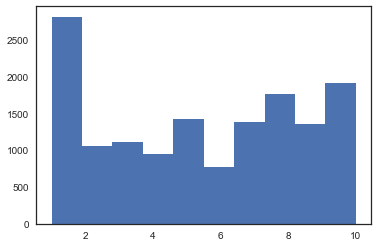

In [362]:
plt.hist(df_no_outlier.rate)

In [363]:
training, test = train_test_split(df_no_outlier, test_size=0.2, random_state=233)
print(len(training), "train +", len(test), "test")

11622 train + 2906 test


In [364]:
x = training[['vader_pos', 'vader_neg','senticnet_pos', 'senticnet_neg', 'pattern_pos', 'pattern_neg']]
y = training.rate

In [365]:
x_test = test[['vader_pos', 'vader_neg','senticnet_pos', 'senticnet_neg', 'pattern_pos', 'pattern_neg']]
y_test = test.rate

In [366]:
from sklearn import linear_model

In [367]:
reg = linear_model.LinearRegression(normalize=True)

In [368]:
reg.fit(x,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [369]:
pre_y = reg.predict(x_test)

In [370]:
from sklearn import metrics

In [371]:
a = metrics.mean_squared_error(y_test, pre_y)
a**0.5

1.9406432944084335

In [372]:
reg.coef_

array([ 8.29341338, 11.68692779,  3.80035772,  2.39473194,  7.89877248,
        5.82938652])

In [237]:
import statsmodels.api as sm

In [238]:
X = x
y = y

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                   rate   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     135.2
Date:                Fri, 27 Apr 2018   Prob (F-statistic):          1.71e-162
Time:                        16:03:02   Log-Likelihood:                -12392.
No. Observations:                6982   AIC:                         2.480e+04
Df Residuals:                    6975   BIC:                         2.485e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.5055      0.167     15.044

In [184]:
x = training[['vader_pos', 'vader_neg','pattern_pos', 'pattern_neg']]
y = training.rate

In [185]:
x_test = test[['vader_pos', 'vader_neg', 'pattern_pos', 'pattern_neg']]
y_test = test.rate

In [186]:
X = x
y = y

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                   rate   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     139.5
Date:                Fri, 27 Apr 2018   Prob (F-statistic):          4.80e-114
Time:                        15:55:39   Log-Likelihood:                -9255.7
No. Observations:                5861   AIC:                         1.852e+04
Df Residuals:                    5856   BIC:                         1.855e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.3763      0.065     36.472      

In [187]:
reg.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [188]:
pre_y = reg.predict(x_test)

In [189]:
metrics.mean_squared_error(y_test, pre_y)

1.4850819827932684

In [190]:
est2.ssr

8075.598179973266

In [191]:
import matplotlib.pyplot as plt

In [192]:
import seaborn as sns
import numpy as np

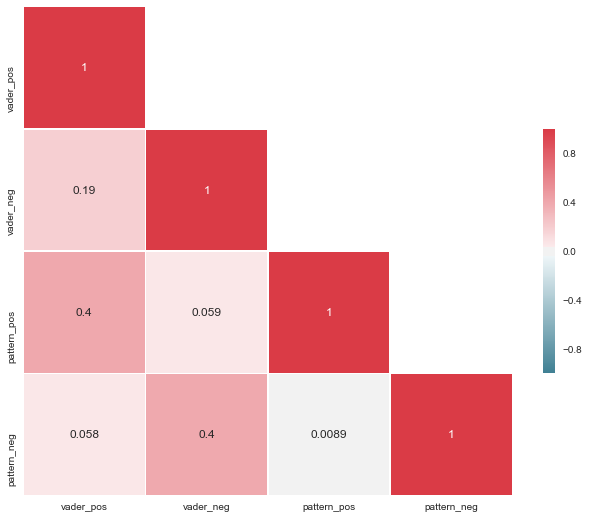

In [193]:
sns.set(style="white")

d = x

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask, +1)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,  mask = mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

In [194]:
# backwards 

x = training[['vader_pos', 'vader_neg','senticnet_pos', 'senticnet_neg', 'pattern_pos', 'pattern_neg']]
y = training.rate
n = y.size

while True:
    nvars = x.shape[1] #total number of features before removing one
    q = 1 #1 var to remove
    p = nvars - q # remaining variables

    # get residual when using all features
    x2 = sm.add_constant(x)
    boston_model = sm.OLS(y,x2).fit()
    ssres0=boston_model.ssr

    # now get residule after removing 
    fvalues = []
    for i in range(1, nvars + 1):
        col = x2.columns[i]
        x2_cut = x2.drop(col, 1)
        boston_model_cut = sm.OLS(y,x2_cut).fit()
        ssres1=boston_model_cut.ssr
        F = (ssres1-ssres0)/q/(ssres0/(n-p-q-1))
        print("if removing column ", col," ssres_removed = ", ssres1," ssres_orig=",ssres0," F=", F)
        fvalues.append([col, F])  # stored [column name, F]
    sortedF = sorted(fvalues, key=lambda x: x[1])
    lowestF = sortedF[0][1]
    if lowestF < 1.07:
        print("removing column", sortedF[0][0])
        x = x.drop(sortedF[0][0], 1)
    else:
        print("STOP: no F-to-remove < 1.07 !!!")
        break

if removing column  vader_pos  ssres_removed =  8081.711834099415  ssres_orig= 8063.333610608737  F= 13.34263538009613
if removing column  vader_neg  ssres_removed =  8209.00322258606  ssres_orig= 8063.333610608737  F= 105.7564959724973
if removing column  senticnet_pos  ssres_removed =  8064.509119540911  ssres_orig= 8063.333610608737  F= 0.853422371101401
if removing column  senticnet_neg  ssres_removed =  8074.411718661319  ssres_orig= 8063.333610608737  F= 8.042733647345633
if removing column  pattern_pos  ssres_removed =  8173.242373982104  ssres_orig= 8063.333610608737  F= 79.79403207888815
if removing column  pattern_neg  ssres_removed =  8224.663103543284  ssres_orig= 8063.333610608737  F= 117.12560799869186
removing column senticnet_pos
if removing column  vader_pos  ssres_removed =  8085.091660363765  ssres_orig= 8064.509119540911  F= 14.943349276622751
if removing column  vader_neg  ssres_removed =  8209.475452014874  ssres_orig= 8064.509119540911  F= 105.24854818235639
if r

In [385]:
x = training[['vader_pos', 'vader_neg', 'pattern_neg']]
y = training.rate

In [386]:
x_test = test[['vader_pos', 'vader_neg', 'pattern_neg']]
y_test = test.rate

In [387]:
reg.fit(x,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [388]:
p = reg.predict(x_test)

In [389]:
a = metrics.mean_squared_error(y_test, p)
a**0.5

2.094004873589697

In [390]:
reg.coef_

array([15.56703086, 12.64732207,  5.78603749])